<a href="https://colab.research.google.com/github/rameezw/TM-flowpipes/blob/main/PicardOperator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinary Differential Equation

Let us start with a simple ODE:
$$ \frac{dx}{dt} = t  e^{-x} $$
with $x(0) = 1.0$.

This ODE is not very difficult to solve analytically.

$$\begin{align*}
\int e^{x} dx & = \int t dt  \\
e^x & = \frac{1}{2} t^2 + c & \text{where}\ c\ \text{is the unknown constant of integration} \\
x & = \ln(\frac{t^2}{2} + c)
\end{align*}$$

Knowing that for $t = 0, x(t)  = 1.0$, we have $\ln(c) = 1$ or $c = e$. Thus, the solution is
$$ x(t) = \ln(\frac{t^2}{2} + e ) $$.

## Picard Operator

Note that an operator is a \emph{higher order} function. It takes in a function and returns a function. Differentiation is an operator or so is integration.

For a one dimensional ODE, $\frac{dx}{dt} = f(x, t)$ the Picard operator for the ODE is given by

$$ \textsf{picard}(g) = x(0) + \int_{0}^{t} f( g(s), s ) ds $$

Notice that the input to `picard` is a function $g(t)$. Its output is a new function.

Let's do an example involving the ODE
$ dx/dt = f(x, t) = t e^{-x} $ and $x(0) = 1$

The Picard operator for the ODE is given by

$$ \textsf{picard}(g) = 1 + \int_{0}^t s e^{-g(s)} ds $$

Let us start with a function $g_0(s) = 1$ (the function is constant everywhere).

$$\begin{align*}
g_1 & = \textsf{picard}(g_0) \\
& = 1 + \int_{0}^t s e^{-g_0(s)} ds \\
& = 1 + \int_{0}^t s e^{-1} ds \\
& = 1 + \frac{e^{-1}}{2} t^2 \\
\end{align*}$$

Let us apply the picard operator to $g_1$. Let $\lambda = \frac{1}{2e}$.

$$\begin{align*}
g_2 & = \textsf{picard}(g_1) \\
& = 1 + \int_{0}^t s e^{-g_1(s)} ds \\
& = 1 + \int_0^t s e^{ -1 - \lambda s^2} ds \\
& = 1 + e^{-1}  \int_0^t s e^{ - \lambda s^2} ds \\
& = 1 - 2 e^{-1} \frac{1}{\lambda} ( e^{-\lambda t^2} - 1) \\
& = 2 -  e^{-\lambda t^2}
\end{align*}$$

We do not have the guts to integrate $g_2$ again. Let's try the same using sympy.

In [1]:
import sympy as sp

def picard(g, t):
    h = sp.integrate(t*sp.exp(-g),t )
    return sp.simplify(1 + h - h.subs(t,0))


In [2]:
t = sp.Symbol('t')
g1 = picard(1, t)
display(g1)

t**2*exp(-1)/2 + 1

In [3]:
g2 = picard(g1, t)
display(g2)

2 - exp(-t**2*exp(-1)/2)

In [4]:
g3 = picard(g2, t)
display(g3)

(-Ei(exp(-t**2*exp(-1)/2)) + Ei(1) + E)*exp(-1)

We could try Picard operator once more, but it is not going to work because integrating these functions is hard for humans and computers.

In [5]:
g4 = picard(g3, t)
display(g4)

(Integral(t*exp(exp(-1)*Ei(exp(-t**2*exp(-1)/2))), t) - Integral(t*exp(exp(-1)*Ei(exp(-t**2*exp(-1)/2))), (t, 0)) + exp(exp(-1)*Ei(1) + 1))*exp(-1 - exp(-1)*Ei(1))

Let's plot these functions against the true solution for various values of $t$.

In [6]:
from matplotlib import pyplot as plt
import numpy as np
def plot_fun(g, t, l, c, tmax=3.0,lstyle='--'):
    xValues = np.linspace(0, tmax, 100)
    gValues = [g.subs(t, xi) for xi in xValues ]
    plt.plot(xValues, gValues, label=l,color=c,linestyle=lstyle)


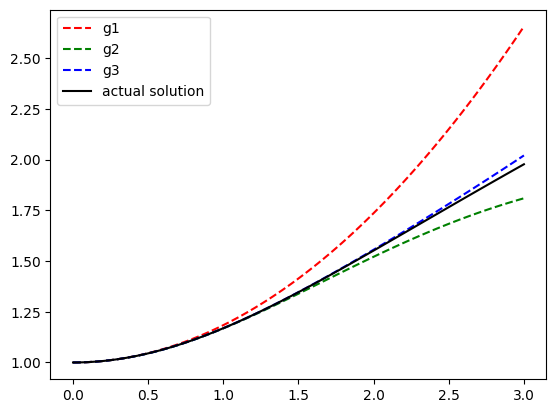

In [7]:

plt.figure(1)
#plot_fun(g0, t, 'g0','r')
plot_fun(g1, t, 'g1', 'r')
plot_fun(g2, t, 'g2','g')
plot_fun(g3, t, 'g3','b')
act_sol = sp.log(t**2/2 + sp.E)
plot_fun(act_sol, t, 'actual solution','k',lstyle='-')
plt.legend()

The key properties of a Picard operator for a Lipschitz continuous ODE are two fold:
  - Starting from any initial solution $g_0$, if we repeatedly apply the Picard operator:
  $$ g_0 \xrightarrow{Picard} g_1 \xrightarrow{Picard} g_2 \xrightarrow \cdots $$
   the solutions $g_i$ get "closer and closer" (converge in a uniform sense) to the actual solution of the ODE.

  - The solution of the ODE is the __unique__ fixed point of the Picard operator. In other words, if we started from the actual solution and applied the Picard operator, we get the solution back.

In [8]:
act_sol = sp.log(t**2/2 + sp.E)
act_sol_picard = picard(act_sol, t)
display(sp.simplify(act_sol_picard))

log(t**2/2 + E)

### Picard Operator for Coupled ODEs

Consider now the coupled system:

$$\begin{array}{rl}
\frac{dx}{dt} & = -x + 0.5 y + 0.1 xy  \\
\frac{dy}{dt} &= -0.2x -0.75 y - 0.05 y^2 \\
\end{array}$$

With $x(0) = 1.5, y(0) = 1.2$.

Since our ODE involves two state variables, the Picard operator takes in two functions $g_x(t), g_y(t)$ and outputs a pair of functions $\hat{g}_x, \hat{g}_y$.

$$ (g_x, g_y) \xrightarrow{Picard} (\hat{g}_x, \hat{g}_y) $$

$$\begin{array}{rl}
\hat{g}_x & = x(0) + \int_0^{t} -g_x(s) + 0.5 g_y(s) + 0.1 g_x(s) g_y(s) ds\\
\hat{g}_y &= y(0) + \int_0^t -0.2 g_x(s) -0.75 g_y(s) -0.05 (g_y(s))^2 ds
\end{array}$$

First let's numerically integrate the ODE to solve it.

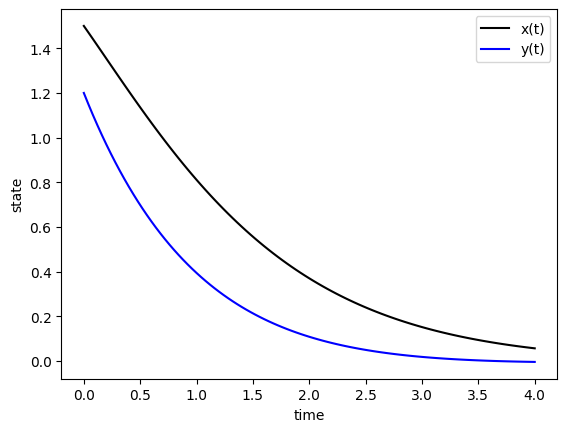

In [9]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

def solve_example2():
        def ode_fun(s, t):
            [x,y] = s # unpack
            dsdt = [ -x + 0.5* y + 0.1 * x* y, -0.2*x - 0.75 * y - 0.05*y**2]
            return dsdt
        s0 = [1.5, 1.2]
        t = np.linspace(0, 4, 101)
        res = odeint(ode_fun, s0,t)
        plt.plot(t, res[:,0],'k',label='x(t)')
        plt.plot(t, res[:,1],'b',label='y(t)')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('state')
        plt.show()
        return t, res

times, numerical_sol = solve_example2()



Let's visualize the same process through Picard iteration.

We will start with two functions: $g_x^{(0)}(t) = x(0) = 1.5$ $g_y^{(0)}(t) = y(0) = 1.2$.

In [10]:
import sympy as sp

def picard_example2(gx, gy, t):
    gx_hat = 1.5 + sp.integrate( -gx + 0.5* gy + 0.1 * gx* gy,t)
    gy_hat = 1.2 + sp.integrate(-0.2*gx - 0.75 * gy - 0.05*gy**2, t)
    return sp.simplify(gx_hat), sp.simplify(gy_hat)

In [13]:
t = sp.Symbol('t') # create a symbol
(gx1, gy1) = picard_example2(1.5, 1.2, t )
display(('gx1=', gx1, 'gy1=', gy1))
(gx2, gy2) = picard_example2(gx1, gy1, t)
display(('gx2=', gx2, 'gy2=', gy2))
(gx3, gy3) = picard_example2(gx2, gy2, t)
display((gx3, gy3))
(gx4, gy4) = picard_example2(gx3, gy3, t)
display(( gx4,  gy4))
(gx5, gy5) = picard_example2(gx4, gy4, t)
display(( gx5, gy5))


('gx1=', 1.5 - 0.72*t, 'gy1=', 1.2 - 1.272*t)

('gx2=',
 0.030528*t**3 - 0.0966*t**2 - 0.72*t + 1.5,
 'gy2=',
 -0.0269664*t**3 + 0.62532*t**2 - 1.272*t + 1.2)

(-1.17604322742857e-5*t**7 + 0.00036157872*t**6 - 0.0015964344*t**5 - 0.01928208*t**4 + 0.19435*t**3 - 0.0966*t**2 - 0.72*t + 1.5,
 -5.19419092114286e-6*t**7 + 0.0002810438208*t**6 - 0.00459627624*t**5 + 0.024223968*t**4 - 0.2018692*t**3 + 0.62532*t**2 - 1.272*t + 1.2)

(4.07239536985402e-13*t**15 - 3.70236123237668e-11*t**14 + 1.26127573453755e-9*t**13 - 1.91276102771657e-8*t**12 + 1.09472667794259e-7*t**11 + 2.47307753043621e-7*t**10 - 9.11612423933028e-6*t**9 + 9.31694256340286e-5*t**8 - 0.00070922727208*t**7 + 0.002204831378*t**6 + 0.00329729616*t**5 - 0.083744625*t**4 + 0.19435*t**3 - 0.0966*t**2 - 0.72*t + 1.5,
 -8.99320644176096e-14*t**15 + 1.04271090174476e-11*t**14 - 4.87436545552337e-10*t**13 + 1.18131579216793e-8*t**12 - 1.67449284770451e-7*t**11 + 1.71322171293569e-6*t**10 - 1.55955139250519e-5*t**9 + 0.000102380182062531*t**8 - 0.000636257438318857*t**7 + 0.0033371034588*t**6 - 0.012489490704*t**5 + 0.054074227*t**4 - 0.2018692*t**3 + 0.62532*t**2 - 1.272*t + 1.2)

(-1.18141587979254e-28*t**31 + 2.52531364561175e-26*t**30 - 2.40683381257562e-24*t**29 + 1.3474675615004e-22*t**28 - 4.92459413354597e-21*t**27 + 1.23998681839052e-19*t**26 - 2.22760163662906e-18*t**25 + 2.93836770419161e-17*t**24 - 2.88784809229501e-16*t**23 + 1.9899621484614e-15*t**22 - 5.60714873371555e-15*t**21 - 8.20782646156385e-14*t**20 + 1.67419529586735e-12*t**19 - 1.86999680127719e-11*t**18 + 1.56972822661685e-10*t**17 - 1.04478898987856e-9*t**16 + 5.6775066873453e-9*t**15 - 2.43810270985994e-8*t**14 + 7.38987072246991e-8*t**13 - 6.92155885756195e-8*t**12 - 9.25018850360665e-7*t**11 + 8.32299250361855e-6*t**10 - 5.95466363545703e-5*t**9 + 0.000344767539366963*t**8 - 0.001281958704372*t**7 + 0.0016403888416*t**6 + 0.01852323775*t**5 - 0.083744625*t**4 + 0.19435*t**3 - 0.0966*t**2 - 0.72*t + 1.5,
 -1.3044800339376e-29*t**31 + 3.12577146615511e-27*t**30 - 3.38615434637856e-25*t**29 + 2.1946198852679e-23*t**28 - 9.51975327127151e-22*t**27 + 2.94548092386618e-20*t**26 - 6.82650949

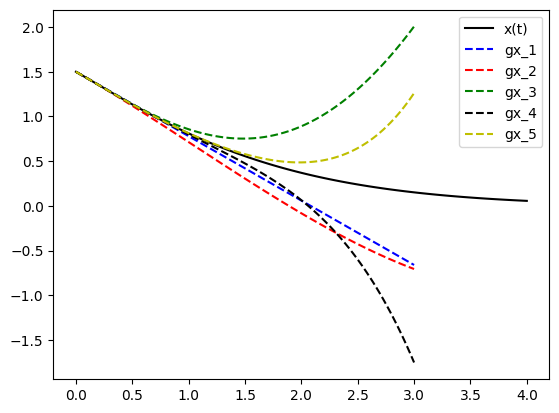

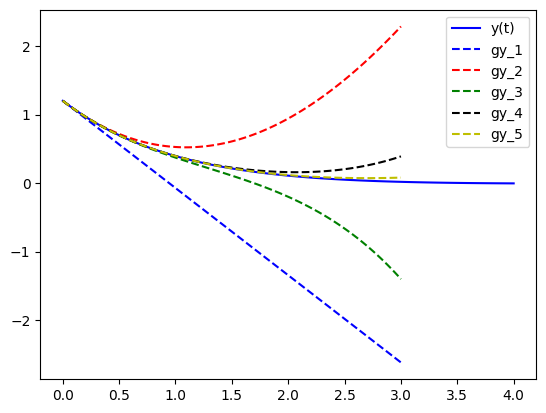

In [14]:
plt.figure(1)
plt.plot(times, numerical_sol[:,0],'k',label='x(t)')
plot_fun(gx1, t, 'gx_1','b',3.0, '--')
plot_fun(gx2, t, 'gx_2','r',3.0,'--')
plot_fun(gx3, t, 'gx_3', 'g',3.0,'--')
plot_fun(gx4, t, 'gx_4','k', 3.0, '--')
plot_fun(gx5, t, 'gx_5','y', 3.0, '--')
plt.legend()

plt.figure(2)
plt.plot(times, numerical_sol[:,1],'b',label='y(t)')
plot_fun(gy1, t, 'gy_1','b',3.0, '--')
plot_fun(gy2, t, 'gy_2','r',3.0,'--')
plot_fun(gy3, t, 'gy_3', 'g',3.0,'--')
plot_fun(gy4, t, 'gy_4','k', 3.0, '--')
plot_fun(gy5, t, 'gy_5','y', 3.0, '--')
plt.legend()

In this example, the RHS of the ODE is a polynomial over $x, y$. Therefore since $g_0(x), g_0(y)$ are polynomials we have that each Picard iterate is a polynomial.

In fact, suppose we started the Picard iteration from $g_0(x) = x(0)$ the constant function equal to the initial condition. We perform Picard iterations successively to obtain functions $g_1, g_2, g_3, \ldots$ wherein each subsequent function is obtained by applying Picard operator on the previous one.

Let $\varphi(t)$ be the actual solution of the ODE. It satisfies:
  - $\varphi(0) = x(0)$
  - $\frac{d}{dt} \varphi(t) = f(t, \varphi(t))$ for all time $t$. This simply says that $\varphi$ satisfies the ODE equation $\frac{d}{dt} x = f(t, x)$ in the first place.

__TO BE CONTINUED__


**EXAMPLE 3** \\
**Moore-Greitzer** jet engine model (no-stall mode):

$$\begin{array}{rl}
\frac{dx}{dt} & = -y + 1.5 x^2 - 0.5 x^3  \\
\frac{dy}{dt} &= x \\
\end{array}$$

With $x(0) = 0, y(0) = -1$.

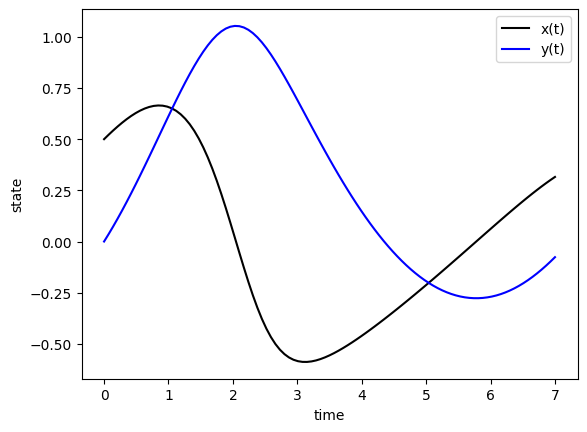

In [21]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

def solve_example3():
        def ode_fun(s, t):
            [x,y] = s # unpack
            dsdt = [ -y + 1.5 * x**2 - 0.5 * x**3, x]
            return dsdt
        s0 = [0.5, 0]
        t = np.linspace(0, 7, 101)
        res = odeint(ode_fun, s0,t)
        plt.plot(t, res[:,0],'k',label='x(t)')
        plt.plot(t, res[:,1],'b',label='y(t)')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('state')
        plt.show()
        return t, res

times, numerical_sol2 = solve_example3()


In [22]:
import sympy as sp

def picard_example3(gx, gy, t):
    gx_hat = 0.5 + sp.integrate(  -gy + 1.5 * gx**2 - 0.5 * gx**3,t)
    gy_hat = 0 + sp.integrate(gx, t)
    return sp.simplify(gx_hat), sp.simplify(gy_hat)

In [23]:
t = sp.Symbol('t') # create a symbol
(gx1, gy1) = picard_example3(0.5, 0, t )
display(('gx1=', gx1, 'gy1=', gy1))
(gx2, gy2) = picard_example3(gx1, gy1, t)
display(('gx2=', gx2, 'gy2=', gy2))
(gx3, gy3) = picard_example3(gx2, gy2, t)
display((gx3, gy3))
(gx4, gy4) = picard_example3(gx3, gy3, t)
display(( gx4,  gy4))
(gx5, gy5) = picard_example3(gx4, gy4, t)
display(( gx5, gy5))

('gx1=', 0.3125*t + 0.5, 'gy1=', 0.5*t)

('gx2=',
 -0.003814697265625*t**4 + 0.0244140625*t**3 - 0.07421875*t**2 + 0.3125*t + 0.5,
 'gy2=',
 t*(0.15625*t + 0.5))

(2.1350442781253e-9*t**13 - 4.44089209850063e-8*t**12 + 4.57331142652865e-7*t**11 - 3.48336470779032e-6*t**10 + 2.17890677352746e-5*t**9 - 0.000110780820250511*t**8 + 0.000476236854280744*t**7 - 0.00177741050720215*t**6 + 0.00443115234375*t**5 - 0.005645751953125*t**4 - 0.0555013020833333*t**3 - 0.07421875*t**2 + 0.3125*t + 0.5,
 t*(-0.000762939453125*t**4 + 0.006103515625*t**3 - 0.0247395833333333*t**2 + 0.15625*t + 0.5))

(-1.21655198456632e-28*t**40 + 7.78593270122442e-27*t**39 - 2.48500149471194e-25*t**38 + 5.34308322360509e-24*t**37 - 8.78478782059691e-23*t**36 + 1.18273911646813e-21*t**35 - 1.35874313677764e-20*t**34 + 1.36808085170299e-19*t**33 - 1.22978142965758e-18*t**32 + 9.99756094886543e-18*t**31 - 7.41580001248808e-17*t**30 + 5.04825250505902e-16*t**29 - 3.16508128008399e-15*t**28 + 1.83095522642464e-14*t**27 - 9.7752796808941e-14*t**26 + 4.8104431095163e-13*t**25 - 2.17565558909107e-12*t**24 + 8.99949654703031e-12*t**23 - 3.38097382762041e-11*t**22 + 1.14433374745403e-10*t**21 - 3.46981748922831e-10*t**20 + 9.5047383082578e-10*t**19 - 2.47858783013238e-9*t**18 + 7.09146094336112e-9*t**17 - 2.54994048921613e-8*t**16 + 1.03883477691404e-7*t**15 - 3.90093662744681e-7*t**14 + 1.15118044350049e-6*t**13 - 1.68845904812715e-6*t**12 - 1.94036195215163e-6*t**11 + 1.70840295037826e-5*t**10 + 6.84434313957811e-5*t**9 - 0.000293495142388911*t**8 + 2.65694799877347e-5*t**7 + 0.00247139930725098*t**6 - 0.

(7.44006360966483e-87*t**121 - 1.44039631483111e-84*t**120 + 1.39318842743954e-82*t**119 - 8.98939235116028e-81*t**118 + 4.35882459949809e-79*t**117 - 1.69614002881684e-77*t**116 + 5.5229320752067e-76*t**115 - 1.54913348308461e-74*t**114 + 3.82353791363146e-73*t**113 - 8.44046057222809e-72*t**112 + 1.68793619925718e-70*t**111 - 3.08972163147218e-69*t**110 + 5.22078776406583e-68*t**109 - 8.20107312088016e-67*t**108 + 1.20477656767753e-65*t**107 - 1.66357716791553e-64*t**106 + 2.16854501835129e-63*t**105 - 2.67864937485076e-62*t**104 + 3.14561457531707e-61*t**103 - 3.52191456171187e-60*t**102 + 3.76899343876757e-59*t**101 - 3.86371130980542e-58*t**100 + 3.80157665160931e-57*t**99 - 3.59626673116347e-56*t**98 + 3.2759152462992e-55*t**97 - 2.87735854446044e-54*t**96 + 2.43981380249606e-53*t**95 - 1.99931674942305e-52*t**94 + 1.58480447452084e-51*t**93 - 1.21617805730411e-50*t**92 + 9.04190570957141e-50*t**91 - 6.5168482762894e-49*t**90 + 4.5558187020763e-48*t**89 - 3.09064127856832e-47*t**

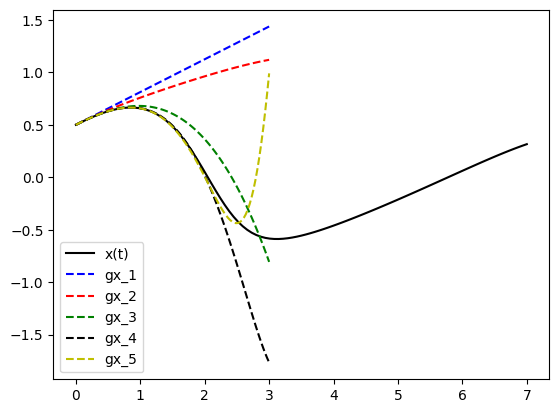

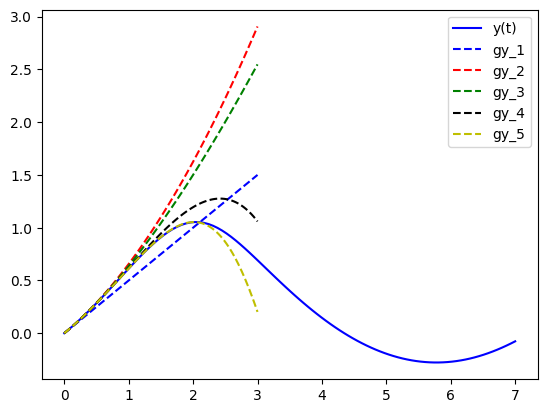

In [26]:
plt.figure(1)
plt.plot(times, numerical_sol2[:,0],'k',label='x(t)')
plot_fun(gx1, t, 'gx_1','b',3.0, '--')
plot_fun(gx2, t, 'gx_2','r',3.0,'--')
plot_fun(gx3, t, 'gx_3', 'g',3.0,'--')
plot_fun(gx4, t, 'gx_4','k', 3.0, '--')
plot_fun(gx5, t, 'gx_5','y', 3.0, '--')
plt.legend()

plt.figure(2)
plt.plot(times, numerical_sol2[:,1],'b',label='y(t)')
plot_fun(gy1, t, 'gy_1','b',3.0, '--')
plot_fun(gy2, t, 'gy_2','r',3.0,'--')
plot_fun(gy3, t, 'gy_3', 'g',3.0,'--')
plot_fun(gy4, t, 'gy_4','k', 3.0, '--')
plot_fun(gy5, t, 'gy_5','y', 3.0, '--')
plt.legend()

**EXAMPLE 4**
\\
*Competing species* model:

$$\begin{array}{rl}
\frac{dx}{dt} & = x (1 - x -y)  \\
\frac{dy}{dt} &= y(3/4 - y - x/2) \\
\end{array}$$

With $x(0) = 0.3, y(0) = 0.3$.

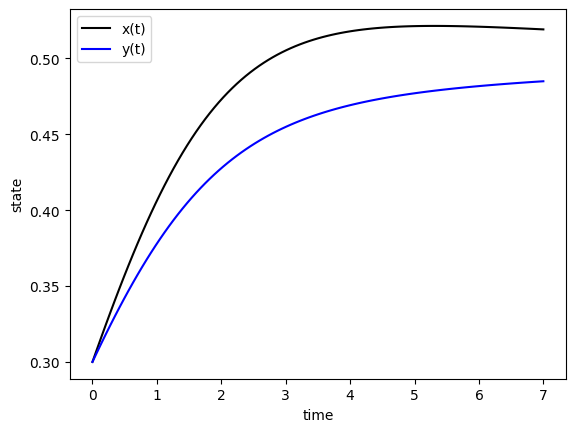

In [29]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

def solve_example4():
        def ode_fun(s, t):
            [x,y] = s # unpack
            dsdt = [ x *(1 - x -y), y*(3/4 - y - x/2)]
            return dsdt
        s0 = [0.3, 0.3]
        t = np.linspace(0, 7, 101)
        res = odeint(ode_fun, s0,t)
        plt.plot(t, res[:,0],'k',label='x(t)')
        plt.plot(t, res[:,1],'b',label='y(t)')
        plt.legend()
        plt.xlabel('time')
        plt.ylabel('state')
        plt.show()
        return t, res

times, numerical_sol3 = solve_example4()


In [35]:
import sympy as sp

def picard_example4(gx, gy, t):
    gx_hat = 0.3 + sp.integrate( gx *(1 - gx - gy),t)
    gy_hat = 0.3 + sp.integrate(gy*(3/4 - gy - gx/2), t)
    return sp.simplify(gx_hat), sp.simplify(gy_hat)

In [36]:
t = sp.Symbol('t') # create a symbol
(gx1, gy1) = picard_example4(0.3, 0.3, t )
display(('gx1=', gx1, 'gy1=', gy1))
(gx2, gy2) = picard_example4(gx1, gy1, t)
display(('gx2=', gx2, 'gy2=', gy2))
(gx3, gy3) = picard_example4(gx2, gy2, t)
display((gx3, gy3))
(gx4, gy4) = picard_example4(gx3, gy3, t)
display(( gx4,  gy4))
(gx5, gy5) = picard_example4(gx4, gy4, t)
display(( gx5, gy5))

('gx1=', 0.12*t + 0.3, 'gy1=', 0.09*t + 0.3)

('gx2=',
 -0.0084*t**3 - 0.00750000000000001*t**2 + 0.12*t + 0.3,
 'gy2=',
 -0.0045*t**3 - 0.009*t**2 + 0.09*t + 0.3)

(-1.548e-5*t**7 - 3.9225e-5*t**6 + 0.00063765*t**5 + 0.00101625*t**4 - 0.00775*t**3 - 0.00750000000000001*t**2 + 0.12*t + 0.3,
 -5.59285714285714e-6*t**7 - 2.26125e-5*t**6 + 0.00026865*t**5 + 0.000939375*t**4 - 0.004125*t**3 - 0.009*t**2 + 0.09*t + 0.3)

(-2.17471885714286e-11*t**15 - 1.27416237244898e-10*t**14 + 1.92623503228022e-9*t**13 + 1.05557221205357e-8*t**12 - 7.14081898051948e-8*t**11 - 3.52653558482143e-7*t**10 + 1.91967377232143e-6*t**9 + 7.54126808035714e-6*t**8 - 4.29138839285714e-5*t**7 - 0.0001136425*t**6 + 0.0005497125*t**5 + 0.001004375*t**4 - 0.00775*t**3 - 0.00750000000000001*t**2 + 0.12*t + 0.3,
 -4.97125102040816e-12*t**15 - 3.84034017857143e-11*t**14 + 4.54824846840659e-10*t**13 + 3.77068650669643e-9*t**12 - 1.68335771347403e-8*t**11 - 1.48711297098214e-7*t**10 + 5.09260044642857e-7*t**9 + 3.964078125e-6*t**8 - 1.36117098214286e-5*t**7 - 8.190375e-5*t**6 + 0.0002143125*t**5 + 0.000915*t**4 - 0.004125*t**3 - 0.009*t**2 + 0.09*t + 0.3)

(-1.87435788431612e-23*t**31 - 2.33682466556396e-22*t**30 + 2.83169786462674e-21*t**29 + 4.34423150709538e-20*t**28 - 1.79171984891164e-19*t**27 - 3.69768383254198e-18*t**26 + 6.82120921732376e-18*t**25 + 2.01642472268455e-16*t**24 - 2.11548689652546e-16*t**23 - 8.26304080159373e-15*t**22 + 6.43578967321029e-15*t**21 + 2.71093323852354e-13*t**20 - 1.99484221722141e-13*t**19 - 7.29061716414925e-12*t**18 + 6.71849870621639e-12*t**17 + 1.67134410342044e-10*t**16 - 2.13781111152743e-10*t**15 - 3.34420890971678e-9*t**14 + 5.62753681064365e-9*t**13 + 5.78501295608978e-8*t**12 - 1.2978908862013e-7*t**11 - 8.7445996796875e-7*t**10 + 2.50438328249008e-6*t**9 + 1.10906440848214e-5*t**8 - 3.64256428571429e-5*t**7 - 0.000111250625*t**6 + 0.0005509375*t**5 + 0.001004375*t**4 - 0.00775*t**3 - 0.00750000000000001*t**2 + 0.12*t + 0.3,
 -2.54092591600873e-24*t**31 - 3.72039320182673e-23*t**30 + 3.56349897008081e-22*t**29 + 7.34375759381488e-21*t**28 - 1.63071577582644e-20*t**27 - 6.60415432553053e-19*t

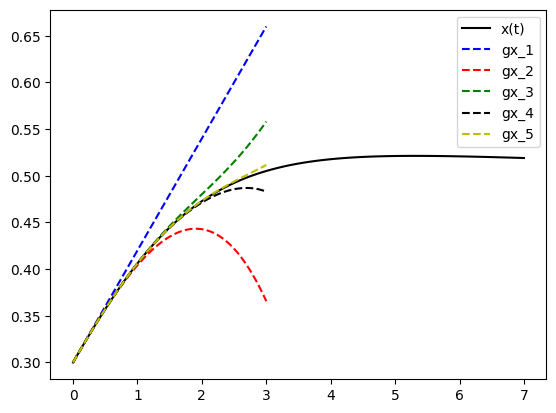

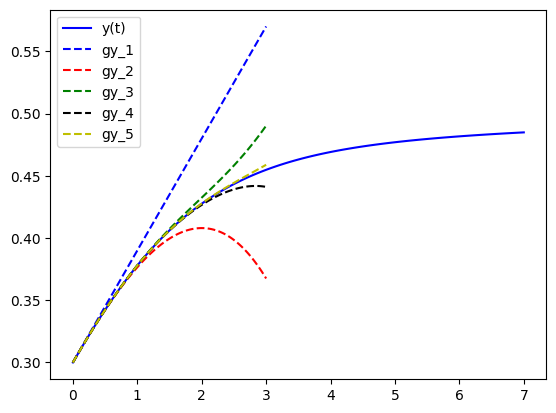

In [39]:
plt.figure(1)
plt.plot(times, numerical_sol3[:,0],'k',label='x(t)')
plot_fun(gx1, t, 'gx_1','b',3.0, '--')
plot_fun(gx2, t, 'gx_2','r',3.0,'--')
plot_fun(gx3, t, 'gx_3', 'g',3.0,'--')
plot_fun(gx4, t, 'gx_4','k', 3.0, '--')
plot_fun(gx5, t, 'gx_5','y', 3.0, '--')
plt.legend()

plt.figure(2)
plt.plot(times, numerical_sol3[:,1],'b',label='y(t)')
plot_fun(gy1, t, 'gy_1','b',3.0, '--')
plot_fun(gy2, t, 'gy_2','r',3.0,'--')
plot_fun(gy3, t, 'gy_3', 'g',3.0,'--')
plot_fun(gy4, t, 'gy_4','k', 3.0, '--')
plot_fun(gy5, t, 'gy_5','y', 3.0, '--')
plt.legend()